In [1]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dists
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, multivariate_normal
from anesthetic.plot import kde_plot_1d, kde_contour_plot_2d
from torch_utils import get_limits, visualise_tension, visualise_coordinate
from np_utils import simple_data, curved_data, uniform_prior_samples
from tension_net import TensionNet, TensionNet1
from bayes_factor import BayesFactor, SuspiciousnessKLDiv, LogSuspiciousness

In [2]:
X0, X1, X_prior = simple_data()
X0_tensor = torch.tensor(X0).float()
X1_tensor = torch.tensor(X1).float()
X_prior_tensor = torch.tensor(X_prior).float()

(<matplotlib.tri.tricontour.TriContourSet at 0x7f25758d4430>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7f25758f28b0>)

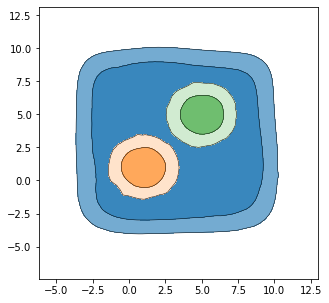

In [3]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [4]:
class WeightClipper(object):
    def __init__(self, width=1):
        self.width = width

    def __call__(self, module):
        if hasattr(module, 'linear1'):
            w = module.linear1.weight.data
            w = w.clamp(-self.width, self.width)
            module.linear1.weight.data = w
        elif hasattr(module, 'linear2'):
            w = module.linear1.weight.data
            w = w.clamp(-self.width, self.width)
            module.linear1.weight.data = w

In [5]:
tension = TensionNet1(2)
criterion = BayesFactor(1000, n_dist_bins=100, n_prior_bins=50)
# criterion = LogSuspiciousness(torch.tensor(3), n_bins=50)
optimizer = optim.SGD(tension.parameters(), lr=0.001)
clipper = WeightClipper()

losses = []
for i in range(500):
    optimizer.zero_grad()
    X0_1d = tension(X0_tensor)
    X1_1d = tension(X1_tensor)
    X_prior_1d = tension(X_prior_tensor)
    
    crit_val = criterion(X0_1d, X1_1d, X_prior_1d)
    loss = torch.log(crit_val)

    # loss = criterion(X0_1d, X1_1d)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    tension.apply(clipper)

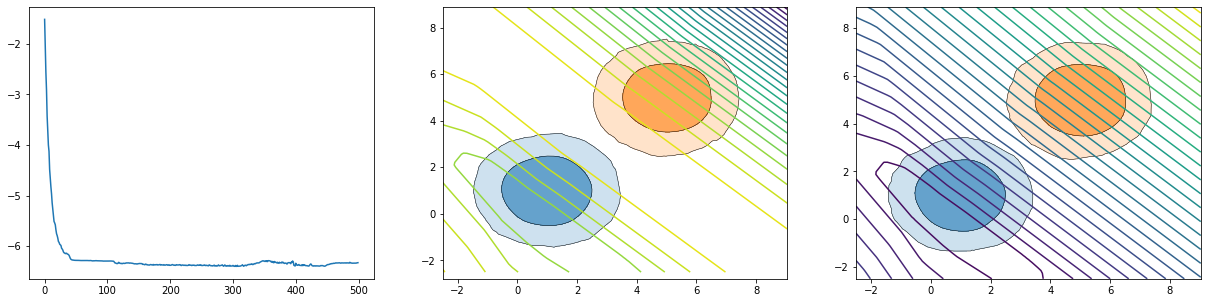

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

axs[0].plot(np.arange(500), losses)
visualise_tension(fig, axs[1], tension, X0, X1)
visualise_coordinate(fig, axs[2], tension, X0, X1)


In [7]:
X0, X1, X_prior = curved_data()
X0_tensor = torch.tensor(X0).float()
X1_tensor = torch.tensor(X1).float()
X_prior_tensor = torch.tensor(X_prior).float()

(<matplotlib.tri.tricontour.TriContourSet at 0x7f256efe1880>,
 <matplotlib.tri.tricontour.TriContourSet at 0x7f256efe27c0>)

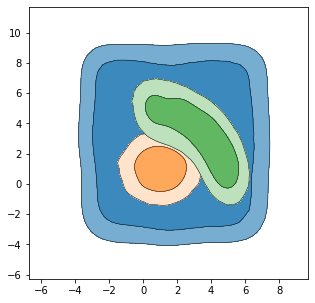

In [8]:
fig, axs = plt.subplots(figsize=(5, 5))

kde_contour_plot_2d(axs, X_prior[:, 0], X_prior[:, 1])
kde_contour_plot_2d(axs, X0[:, 0], X0[:, 1])
kde_contour_plot_2d(axs, X1[:, 0], X1[:, 1])

In [13]:
tension = TensionNet1(2)
criterion = BayesFactor(1000, n_dist_bins=100, n_prior_bins=50)
# criterion = LogSuspiciousness(torch.tensor(3), n_bins=50)
optimizer = optim.Adam(tension.parameters(), lr=0.001)
clipper = WeightClipper(width=1)

losses = []
for i in range(1000):
    optimizer.zero_grad()
    X0_1d = tension(X0_tensor)
    X1_1d = tension(X1_tensor)
    X_prior_1d = tension(X_prior_tensor)
    
    crit_val = criterion(X0_1d, X1_1d, X_prior_1d)
    loss = torch.log(crit_val)

    # loss = criterion(X0_1d, X1_1d)

    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    tension.apply(clipper)

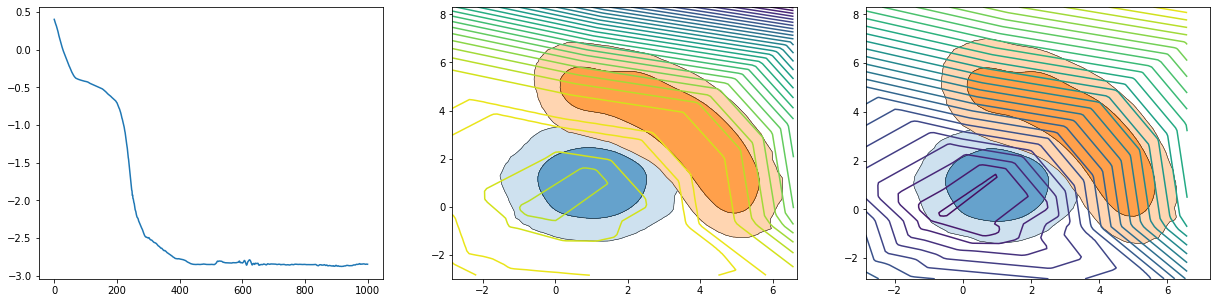

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(21, 5))

axs[0].plot(np.arange(1000), losses)
visualise_tension(fig, axs[1], tension, X0, X1)
visualise_coordinate(fig, axs[2], tension, X0, X1)